<a href="https://colab.research.google.com/github/Ananthzeke/Deep-Learning/blob/main/Notebooks-Tensorflow/Sentence_Classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2022-06-12 10:03:51--  http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   736KB/s    in 0.3s    

2022-06-12 10:03:51 (736 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



In [2]:
!unzip smsspamcollection.zip

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
dataframe=pd.read_csv('/content/SMSSpamCollection',sep='\t',header=None)

In [ ]:
dataframe.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
dataframe[0].unique()

array(['ham', 'spam'], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


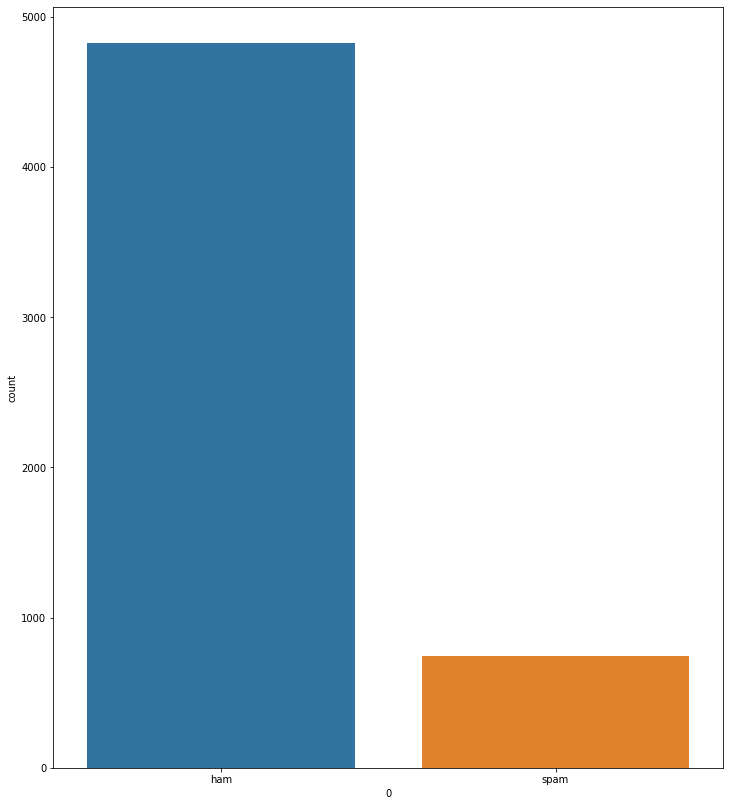

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,14))
sns.countplot(dataframe[0])

In [ ]:
ham_msg=dataframe[dataframe[0]=='ham']
spam_msg=dataframe[dataframe[0]=='spam']

In [ ]:
ham_msg

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...
...,...,...
5565,ham,Huh y lei...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
ham_msg=ham_msg.sample(n=len(spam_msg),random_state=42)

In [ ]:
ham_msg.shape,spam_msg.shape

((747, 2), (747, 2))

In [ ]:
balanced_data=ham_msg.append(spam_msg).reset_index(drop=True)
balanced_data

,0,1
0,ham,If i not meeting ü all rite then i'll go home ...
1,ham,"I.ll always be there, even if its just in spir..."
2,ham,"Sorry that took so long, omw now"
3,ham,I thk 50 shd be ok he said plus minus 10.. Did...
4,ham,Dunno i juz askin cos i got a card got 20% off...
...,...,...
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of ham and spam email messages (after downsampling)')

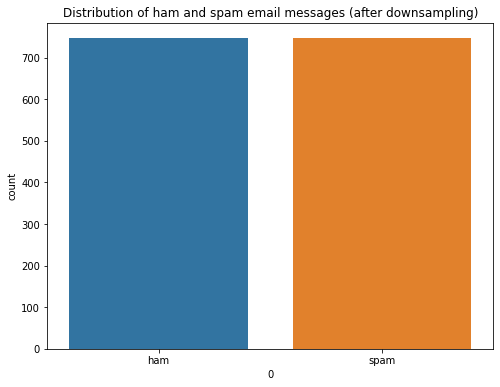

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(balanced_data[0])
plt.title('Distribution of ham and spam email messages (after downsampling)')

In [ ]:
balanced_data['label']=balanced_data[0].map({'ham':0,'spam':1})

In [ ]:
shuffled_data=balanced_data.sample(frac=1)
shuffled_data

,0,1,label
105,ham,"Not much, just some textin'. How bout you?",0
869,spam,"SMSSERVICES. for yourinclusive text credits, p...",1
509,ham,You bad girl. I can still remember them,0
83,ham,Its so common hearin How r u? Wat r u doing? H...,0
1037,spam,Well done ENGLAND! Get the official poly ringt...,1
...,...,...,...
1052,spam,"URGENT! Your mobile No 07xxxxxxxxx won a £2,00...",1
167,ham,Dude ive been seeing a lotta corvettes lately,0
22,ham,This pen thing is beyond a joke. Wont a Biro d...,0
400,ham,"Watching cartoon, listening music &amp; at eve...",0


In [ ]:
train,test,val=np.split(shuffled_data,[int(0.8*len(shuffled_data)), int(0.9*len(shuffled_data))])

In [ ]:
def tensor_dataset(data_):
  X=data_[1]
  Y=data_['label']
  ds=tf.data.Dataset.from_tensor_slices((X,Y)).batch(64)
  return ds

In [ ]:
train_ds=tensor_dataset(train)
test_ds=tensor_dataset(test)
val_ds=tensor_dataset(val)

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
import re,string

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, ' \d+', ' ')
    return tf.strings.regex_replace(
        stripped_html,
        f'[{re.escape(string.punctuation)}]',
        ''
    )

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
vectorize_layer.adapt(train_ds.map(lambda x, y: x))

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=30,
                    validation_data=val_ds)

Epoch 1/30
19/19 [==============================] - 33s 914ms/step - loss: 0.6928 - accuracy: 0.5096 - val_loss: 0.6921 - val_accuracy: 0.4600
Epoch 2/30
19/19 [==============================] - 11s 600ms/step - loss: 0.6915 - accuracy: 0.5096 - val_loss: 0.6904 - val_accuracy: 0.4600
Epoch 3/30
19/19 [==============================] - 11s 599ms/step - loss: 0.6893 - accuracy: 0.5096 - val_loss: 0.6876 - val_accuracy: 0.4600
Epoch 4/30
19/19 [==============================] - 11s 596ms/step - loss: 0.6856 - accuracy: 0.5096 - val_loss: 0.6828 - val_accuracy: 0.4600
Epoch 5/30
19/19 [==============================] - 12s 652ms/step - loss: 0.6789 - accuracy: 0.5096 - val_loss: 0.6741 - val_accuracy: 0.4600
Epoch 6/30
19/19 [==============================] - 11s 599ms/step - loss: 0.6669 - accuracy: 0.5096 - val_loss: 0.6579 - val_accuracy: 0.4600
Epoch 7/30
19/19 [==============================] - 11s 598ms/step - loss: 0.6443 - accuracy: 0.5096 - val_loss: 0.6272 - val_accuracy: 0.4600

In [ ]:
import matplotlib.pyplot as plt 
history = history.history


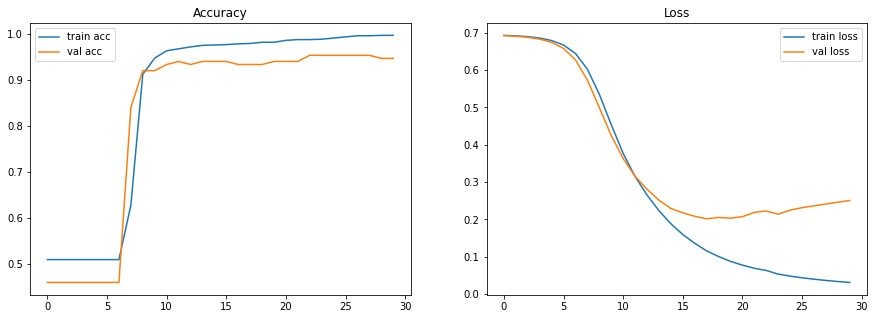

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()
